# *Modules

In [1]:
from glob import glob
import sys
import os
# import psutil
from os.path import join, dirname
from os.path import getsize

import pickle as pkl
import numpy as np
import pandas as pd
import scipy.stats
import statannot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multitest

from tqdm import tqdm

In [2]:
%matplotlib inline

# font = {
#     'family': 'normal'
#     , 'weight': 'bold'
#     , 'size': 22
# }
# matplotlib.rc('font', **font)

$\textbf{Nilearn}$ enables approachable and versatile analyses of brain volumes. It provides statistical and machine-learning tools : https://nilearn.github.io/

In [3]:
# import nilearn.masking
from nilearn import plotting as nplt
from nilearn import image as niimg
import nilearn.decoding

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


$\textbf{Scikit-learn}$ is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection and evaluation, and many other utilities : https://scikit-learn.org/stable/#

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
# from sklearn.svm import LinearSVC

In [5]:
from datetime import date
today = date.today().strftime("%Y%m%d")

# *Create variables that point to the location of the configuration

In [6]:
dir_script = '.'
dir_root = '/home/sungbeenpark/GA'
dir_data = '/mnt/sda2/GA'

In [7]:
dir_fmri = dir_data + '/fmri_data'
dir_LSS = dir_fmri + '/beta_map'
dir_mask = dir_fmri + '/masks'
dir_fig = dir_root

In [8]:
list_subj = ['01', '02', '05', '07', '08', '11', '12', '13', '14', '15',
             '18', '19', '20', '21', '23', '26', '27', '28', '29', '30',
             '31', '32', '33', '34', '35', '36', '37', '38', '42', '44']
list_stage = ['early_practice', 'early_unpractice', 'late_practice', 'late_unpractice']

In [9]:
## background image
img_bg = join('/mnt/sda2/MNI152_2009_template.nii.gz')

In [10]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

# *MVPA
#### Multi-voxel pattern analysis (MVPA) is gaining increasing interest in the neuroimaging community because it allows to detect differences between conditions with higher sensitivity than conventional univariate analysis by focusing on the analysis and comparison of distributed patterns of activity. In such a multivariate approach, data from individual voxels within a region are jointly analyzed. Furthermore, MVPA is often presented in the context of "brain reading" applications reporting that specific mental states or representational content can be decoded from fMRI activity patterns after performing a "training" or "learning phase. In this context, MVPA tools are often referred to as classifiers or, more generally, learning machines. The latter names stress that many MVPA tools originate from a field called machine learning, a branch of artificial intelligence.

# *SearchLight

Searchlight analysis was introduced in Information-based functional brain mapping (Kriegeskorte et al., 2006), and consists of scanning the brain with a $\textit{searchlight}$. Briefly, a ball of given radius is scanned across the brain volume and the prediction accuracy of a classifier trained on the corresponding voxels is measured.

SearchLight will iterate on the volume and give a score to each voxel. This score is computed by running a classifier on selected voxels. In order to make this score as accurate as possible (and avoid overfitting), cross-validation is used.

An important parameter is the radius of the sphere that will run through the data. The sphere size determines the number of voxels/features to use for classification (i.e. more voxels are included with larger spheres).

In [11]:
from nilearn import datasets, surface
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from nilearn.decoding.searchlight import search_light

In [12]:
## For this we need to get a mesh representing the geometry of the surface.
## We could use an individual mesh, but we first resort to a standard mesh,
## the so-called fsaverage5 template from the FreeSurfer software.
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5') # (10242 nodes)
hemi = 'right'
pial_mesh = fsaverage['pial_' + hemi] # Gifti file, right hemisphere pial surface mesh

# To define the :term:`BOLD` responses to be included within each searchlight "sphere"
# we define an adjacency matrix based on the inflated surface vertices such
# that nearby surfaces are concatenated within the same searchlight.
infl_mesh = fsaverage['infl_' + hemi] # Gifti file, right hemisphere inflated pial
coords, _ = surface.load_surf_mesh(infl_mesh)
nn = neighbors.NearestNeighbors(radius=3.)
adjacency = nn.fit(coords).radius_neighbors_graph(coords).tolil()

In [13]:
hemi = 'right'
radius = 5
with open(join(dir_root, 'MVPA', 'searchlight_surface.%s_hemi.r=%d.pkl'%(hemi, radius)), 'rb') as f:
    Scores = pkl.load(f)

chance = .25

In [14]:
group_score = {}
for stage in list_stage:
    group_score[stage] = np.ones((30,10242)) * np.nan
    for ii, nn in enumerate(list_subj):
        group_score[stage][ii, :] = Scores[(nn, stage)]

In [31]:
# score = Scores[('11', 'early_practice')]
score = group_score['late_practice'] - group_score['early_practice']
score = group_score['late_practice'] - .25
print(score.shape)

tval = np.ones(10242) * np.nan
pval = np.ones(10242) * np.nan
for voxel in range(10242):
    tval[voxel], pval[voxel] = scipy.stats.ttest_1samp(
        score[:,voxel]
        , popmean=0
        , alternative='two-sided'
    )

(30, 10242)


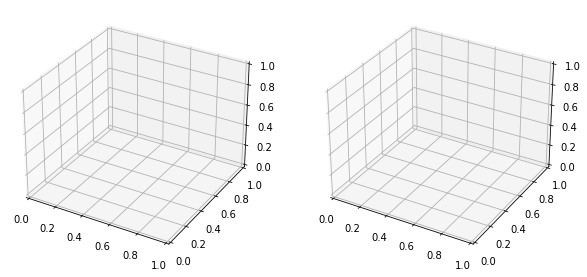

In [32]:
fig, axs = plt.subplots(
    nrows=1, ncols=2, figsize=(10,5)
    , subplot_kw={'projection':'3d'}
)

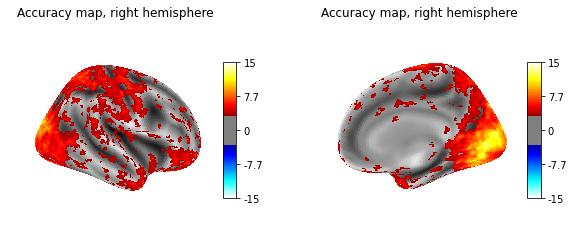

In [30]:
nplt.plot_surf_stat_map(
    infl_mesh
    , tval
    , view='lateral'
#     , view='medial'
#     , view='posterior'
    , hemi=hemi
    , colorbar=True, threshold=3.4
#     , cmap=''
    , bg_map=fsaverage['sulc_' + hemi]
    , title='Accuracy map, %s hemisphere'%(hemi)
    , axes=axs[0]
)
nplt.plot_surf_stat_map(
    infl_mesh
    , tval
    , view='medial'
    , hemi=hemi
    , colorbar=True, threshold=3.4
    , bg_map=fsaverage['sulc_' + hemi]
    , title='Accuracy map, %s hemisphere'%(hemi)
    , axes=axs[1]
)